# Lab Assignment 5: Restoring Clean Images from Noisy Images

## Cleaning Up the Bayes' Theorem Image
Now it's your turn! It's time to design an implement your solution to clean up `./figures/Bayes-noise.png`. Use the pre-processed `./figures/Bayes-pre-processed.png`, provided. Be careful not to over-write these files. Save your cleaned up image with a different file name (for example, `./figures/Bayes-denoised.png`) to display and check your work. **DO NOT use the cautionary tale image, `./bad_figures/Bayes-incorrectly-pre-processed.png` as your starting point.**

You are welcome to copy/paste any of the starter code above in your solution.

The problem statement above is copied here for your convenience.

### Revisiting the Problem Statement:
![A clean image, the corrupted image, and a pairwise MRF](./figures/problem_statement_diagram.png)

The goal of this problem is to recover the clean image (a) from a noisy input (b). Of course, we cannot recover (a) exactly since information has been lost in the noise. The graphical model we use is a pairwise MRF as shown in (c). A pixel has four neighbors. We are going to use Markov Random Fields (MRFs) to model the distribution of natural images and restore the clean image given an noisy input image. Observed image $y_i \in \{-1,+1\}$, and $i = 1,\cdots,D$ indexes pixels in the lattice. The
original noise free image is $x_i \in \{-1, +1\}$. The noisy image $y_i$ is obtained by randomly flipping the sign of pixels with some probability (10% of pixels, in this case).

There are two types of cliques in this MRF. For $\{x_i,y_i\}$, we define the energy function as $-\eta x_i y_i\ (\eta > 0)$.  Lower energy is achieved when $x_i$ and $y_i$ have the same sign and a higher energy when they have the opposite sign. For a pair of variables $\{x_i, x_j\}$ where $i$ and $j$ are indices of neighboring pixels, we want the energy to be lower when they have the same sign than when they have opposite sign. So the energy function is $-\beta x_i j_i\ (\beta > 0)$. Lastly, we have an energy term $hx_i$ for each pixel $i$ to bias the model towards one particular sign (either $+$ or $−$).

The final energy function for the model takes the form

$E(\vec{x}\vec{y}) = h\displaystyle\sum\limits_i x_i - \beta \displaystyle\sum\limits_{\{i,j\}} x_ix_j - \eta\displaystyle\sum\limits_i x_iy_i$

which defines a joint distribution over $\vec{x}$ and $\vec{y}$ given by

$p(\vec{x},\vec{y}) = \dfrac{1}{\vec{\mathcal{Z}}}exp\{-E(\vec{x}\vec{y})\}$

Now implement Coordinate-descent algorithm as below on this:
1. Initialize $\{x_i\} (x_i = y_i)$
2. Loop over $\{x_i\}$. For each $x_i$, fix the neighborhood and see whether $−x_i$ would
decrease the energy. If so, then flip $x_i$; otherwise, continue.
3. Stop when no changes can be made for $x$.

Now make some initial guess for the parameters $h$, $\beta$, $\eta$ so that the above algorithm converges and then adjust them until you can get up to 96% recovery or better. Record your parameter values and the number of iterations when you acheived this recovery.

Save the recovered image and submit it along with your code. The clean image, noisy image, and now the pre-processed images are included in the `figures` folder : `./figures/Bayes.png`, `./figures/Bayes-noise.png`, and `./figures/Bayes-pre-processed.png`

### Write and Run your Own Code

## Import Libraries
In addition to the `IPython.display` and the `PIL` packages, if you would like to use other libraries in this notebook, please include them below.

In [5]:
## ===============================================================
## Library Imports:
## ===============================================================
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Image display functionality
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from IPython.display import Image as disp

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Pixel Manipulation
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from PIL import Image

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Additional Libraries?
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#### Please insert other libraries as needed.

#### I recommend to use these as well; feel free to use different / remove if unnecessary
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from tqdm.notebook import tqdm

In [ ]:
## ===============================================================
## Load images and convert to black and white binary representation
## ===============================================================
# Load the pre-processed noisy image
img_path = "./figures/Bayes-pre-processed.png"
noisy_image = np.array(Image.open(img_path).convert('L'))

# Convert to -1, +1 values as specified in the problem
noisy_image = (noisy_image > 127).astype(int) * 2 - 1
result_image = noisy_image.copy()


def compute_energy_change(image, noisy_image, i, j, h, beta, eta, N=1):
    current_val = image[i, j]
    new_val = -current_val
    delta_h = h * (new_val - current_val)
    neighbor_sum = 0
    # Instead of taking four neighbours, I take 8 (including corners), this seems to perform noticebly better
    for di in range(-N, N+1):
        for dj in range(-N, N+1):
            if di == 0 and dj == 0:
                continue
            ni, nj = i + di, j + dj
            if 0 <= ni < image.shape[0] and 0 <= nj < image.shape[1]:
                weight = 1
                if abs(ni) == abs(nj):
                    weight = 0.8
                neighbor_sum += image[ni, nj] * weight
    delta_beta = -beta * (new_val - current_val) * neighbor_sum
    delta_eta = -eta * (new_val - current_val) * noisy_image[i, j]
    return delta_h + delta_beta + delta_eta


h = 0.0
beta = 1.2
eta = 2.0

for iteration in tqdm(range(50)): # Maximum 50 iterations
    changes_made = 0
    
    # Scan through all pixels
    for i in range(noisy_image.shape[0]):
        for j in range(noisy_image.shape[1]):
            delta_energy = compute_energy_change(result_image, noisy_image, i, j, h, beta, eta)

            if delta_energy < 0:
                result_image[i, j] = -result_image[i, j]
                changes_made += 1
    
    if changes_made == 0:
        print(f"Converged after {iteration + 1} iterations")
        break
    print(f"Iteration {iteration + 1}: {changes_made} changes made")


clean_img_path = "./figures/Bayes.png"
try:
    clean_image = np.array(Image.open(clean_img_path).convert('L'))
    clean_image = (clean_image > 127).astype(int) * 2 - 1
    
    # Calculate and print recovery percentage
    correct_pixels = np.sum(result_image == clean_image)
    total_pixels = result_image.size
    recovery_percentage = correct_pixels / total_pixels * 100
    print(f"Recovery percentage: {recovery_percentage}")
except:
    print("Clean image not found. Can't calculate recovery percentage.")


# Save denoised image
plt.imsave('./figures/Bayes-denoised.png', result_image, cmap='gray', vmin=-1, vmax=1)

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1: 25797 changes made
Iteration 2: 1932 changes made
Iteration 3: 407 changes made
Iteration 4: 155 changes made
Iteration 5: 56 changes made
Iteration 6: 24 changes made
Iteration 7: 17 changes made
Iteration 8: 10 changes made
Iteration 9: 5 changes made
Iteration 10: 2 changes made
Converged after 11 iterations
Recovery percentage: 98.17920864524118


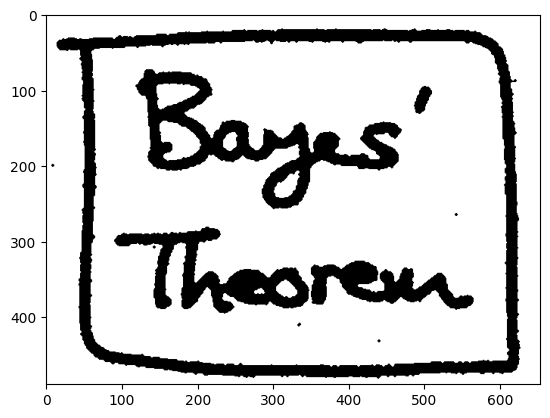

In [45]:
imgplot = plt.imshow(result_image,  cmap='gray', vmin=-1, vmax=1)
plt.savefig(os.path.join(os.curdir,'result.png'))
plt.show()

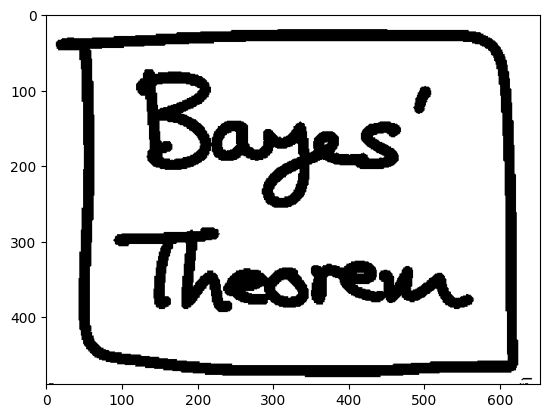

In [ ]:
clean_img = plt.imread('/Users/artur/CS179/engs-106-w25/assignment5/figures/Bayes.png')
clean_img_bw = np.array(Image.fromarray((clean_img * 255).astype(np.uint8)).convert('L'))
clean_img_bw = (clean_img_bw > 127).astype(int) * 2 - 1

plt.imshow(clean_img_bw, cmap='gray')
plt.show()

In [79]:
# Count correctly and incorrectly fixed pixels
noisy_correct = np.sum((noisy_image == clean_img_bw)) / result_image.size
result_correct = np.sum((result_image == clean_img_bw)) / result_image.size
fixed_correctly = np.sum((noisy_image != clean_img_bw) & (result_image == clean_img_bw)) / result_image.size

print(f"Correctly fixed pixels: {fixed_correctly} out of {1-noisy_correct}")
print(f"Incorrectly fixed pixels: {1-result_correct} out of {noisy_correct}")

Correctly fixed pixels: 0.08466070054970826 out of 0.10030455963928131
Incorrectly fixed pixels: 0.018207913547588217 out of 0.8996954403607187


### What to Submit
Please submit the following:

1. A brief post-lab write-up that contains the following for this assignment:

    a. Any paper design that you have.
    
    b. A brief description of your model/algorithm. Justify your design/selection of model parameters as appropriate.
    
    c. An evaluation of your model, including evidence as appropriate.
    
    d. A brief (couple of sentences) reflection on your take-aways from this lab exercise.